## **Project**  
**02805 Social Graphs & Interactions**  

**Group 13** 
- Anna Bøgevang Ekner (s193396)
- Morten Møller Christensen (s204258)


**Inspiration**: https://paperswithcode.com/dataset/reddit  

Nodes are posts, and there is a link between two posts if the same user has commented on both. 

50 random subreddits, each with 20 top/hot posts from this month.

Each node (post) should have the attributes:

- Title of the post
- Upvotes of the post
- Text of the post
- Subreddit name that the post belongs to
- Usernames of comments on that post

Filter posts with a text below some number of words. 


In [61]:
import os
import praw
import json
import warnings
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv

sns.set_style('darkgrid')
sns.set(font_scale=1.)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## **Part 1: Scraping the data**

#### **Part 1.1: Setting up the Reddit API**

In [62]:
def load_API_tokens():
    # Load environment variables from the .env file
    load_dotenv()

    # Retrieve tokens from environment variables
    client_id = os.getenv('CLIENT_ID')
    client_secret = os.getenv('CLIENT_SECRET')
    user_agent = os.getenv('USER_AGENT')

    return client_id, client_secret, user_agent

In [63]:
# Load API tokens
client_id, client_secret, user_agent = load_API_tokens()

# Initialize Reddit instance with credentials from the .env file
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

#### **Part 1.2: Scraping and saving the data**

Only subreddits with a minimum number of subscribers are chosen. \
Top posts, and only posts with non-empty text are chosen. 

n_subreddits = 50, n_posts_per_subreddit = 20. \
Each subreddit is saved as a .json file that contains:

Subreddit information: 
- Name
- Description
- Subscribers
- Posts

Post information: 
- Title
- Author
- Score
- Text
- Subreddit
- URL
- ID
- Comments

Comment information:
- Author
- Score
- Text
- ID

All of this information is stored in case it could become interesting to use in our exploratory analysis. 


In [97]:
def scrape_reddit_data(n_subreddits, n_posts_per_subreddit, min_subscribers, top_all, data_dir):
    """
    Scrape Reddit data for a given number of random subreddits and save the data to JSON files.

    For {n_subreddits} random subreddits with at least {min_subscribers} subscribers, scrapes the 
    top {n_posts_per_subreddit} posts and comments from the past year and saves the data to JSON files.

    Args 
        n_subreddits: Number of random subreddits to fetch (int)
        n_posts_per_subreddit: Number of top posts to fetch per subreddit (int)
        min_subscribers: Minimum number of subscribers for a subreddit to be included (int)
        top_all: Time frame for top posts (e.g., 'all', 'year', 'month', 'week', 'day', 'hour')
        data_dir: Directory to save the JSON files (str)


    """

    # Number of subreddit JSON files already saved
    saved_subreddits = len(os.listdir(data_dir))

    os.makedirs(data_dir, exist_ok=True)

    while saved_subreddits < n_subreddits:

        # Fetch a random subreddit and validate its subscriber count
        random_subreddit = reddit.subreddit("random")
        random_subreddit = reddit.subreddit("soccer")
        if random_subreddit.subscribers < min_subscribers:
            continue

        print(f"Selected subreddit: {random_subreddit.display_name} with {random_subreddit.subscribers} subscribers")

        # Fetch top posts and initialize data structure
        limit = n_posts_per_subreddit * 1000
        top_posts = random_subreddit.top(top_all, limit=limit)

        subreddit_data = {
            "subreddit": random_subreddit.display_name,
            "description": random_subreddit.public_description,
            "subscribers": random_subreddit.subscribers,
            "posts": []
        }

        # Counter for the number of posts without empty text
        saved_posts = 0

        while saved_posts < n_posts_per_subreddit and len(subreddit_data["posts"]) < n_posts_per_subreddit:

            # Get the next top post
            post = next(top_posts)

            # Skip posts with empty text
            if not post.selftext.strip():
                continue

            post_data = {
                "title": post.title,
                "author": post.author.name if post.author else "deleted",
                "score": post.score,
                "text": post.selftext,
                "subreddit": post.subreddit.display_name,
                "url": post.url,
                "id": post.id,
                "comments": []
            }

            # Fetch up to 10 comments per post
            post.comments.replace_more(limit=0)
            post_data["comments"] = [
                {
                    "comment_id": comment.id,
                    "author": comment.author.name if comment.author else "deleted",
                    "body": comment.body,
                    "score": comment.score
                }
                for comment in post.comments.list()
            ]

            saved_posts += 1
            subreddit_data["posts"].append(post_data)

        # Save subreddit data to a JSON file
        file_path = os.path.join(data_dir, f"{random_subreddit.display_name}.json")
        with open(file_path, "w", encoding="utf-8") as f:
            json.dump(subreddit_data, f, indent=4)

        print(f"Data saved to {file_path}\n")
        saved_subreddits += 1

In [98]:
# Scrape and save Reddit data
scrape_reddit_data(n_subreddits = 50, 
                   n_posts_per_subreddit = 20, 
                   min_subscribers = 100000,
                   top_all = "year", 
                   data_dir = "data")

Selected subreddit: soccer with 7806578 subscribers
Data saved to data\soccer.json



#### **Part 1.3: Extracting user comment info of each post**
Possibly save a .txt file for each post that contains the usernames of the comments? \
To make it easier to look for intersections between commenters of different posts, when creating the links.

## **Part 2: Building the graph**

In [110]:
def create_graph(data_dir):
    """
    Build the Reddit undirected graph from the scraped data. Nodes are posts, and a 
    link between two nodes is created when the same user comments on both posts.

    Args
        data_dir: Directory containing the subreddit JSON files (str)

    Returns 
        G: Undirected graph representing the Reddit network (nx.Graph)
    """

    # Initialize the graph
    G = nx.Graph()

    # Add nodes for each post
    for file_name in os.listdir(data_dir):
        with open(os.path.join(data_dir, file_name), "r", encoding="utf-8") as f:
            subreddit_data = json.load(f)

        
        for post in subreddit_data["posts"]:
            # Limit the number of comments to reduce the number of edges
            limited_comments = post["comments"]#[:200]
            G.add_node(post["id"], 
                       title = post["title"], 
                       subreddit = post["subreddit"], 
                       text = post["text"], 
                       comments = limited_comments)

    # List of all nodes
    nodes_list = list(G.nodes(data=True))

    common_commenters_within = 0
    common_commenters_across = 0

    # Add links based on shared commenters
    for i, post1 in enumerate(nodes_list):
        for post2 in nodes_list[i+1:]:

            # Get the comments for each post
            post1_comments = post1[1]["comments"]
            post2_comments = post2[1]["comments"]

            # Get the usernames of the commenters for each post
            post1_commenters = set(comment["author"] for comment in post1_comments)
            post2_commenters = set(comment["author"] for comment in post2_comments)
            # Remove "deleted" from the sets
            post1_commenters.discard("deleted")
            post1_commenters.discard("deleted")

            post2_commenters.discard("AutoModerator")
            post2_commenters.discard("AutoModerator")


            # Find the common commenters between the two posts
            common_commenters = set(post1_commenters).intersection(post2_commenters)

            if common_commenters:
                G.add_edge(post1[0], post2[0])

                if post1[1]['subreddit'] == post2[1]['subreddit']:
                    common_commenters_within += 1
                else:
                    common_commenters_across += 1

    print(f"Number of common commenters within the same subreddit: {common_commenters_within}")
    print(f"Number of common commenters across different subreddits: {common_commenters_across}")
    return G

In [111]:
# Create the Reddit graph
G = create_graph("data")

Number of common commenters within the same subreddit: 7085
Number of common commenters across different subreddits: 12502


In [112]:
print(f"Total number of nodes: {G.number_of_nodes()}")
print(f"Total number of edges: {G.number_of_edges()}")

Total number of nodes: 1000
Total number of edges: 19587


# Degree distribution

In [113]:
# Set the number of top nodes to print
n = 5  # Change this to the desired number

# Get the top n nodes with the largest degree
top_n_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:n]
lowest_n_nodes = sorted(G.degree, key=lambda x: x[1], reverse=False)[:n]

# Print the titles of the top n nodes
print(f"Titles of the top {n} nodes with the largest number of connections:")
for node, degree in top_n_nodes:
    print(f"Title: {G.nodes[node]['title']}, Degree: {degree}, url: {G.nodes[node]['subreddit']}")

print(f"Titles of the top {n} nodes with the smallest number of connections:")
for node, degree in lowest_n_nodes:
    print(f"Title: {G.nodes[node]['title']}, Degree: {degree}, url: {G.nodes[node]['subreddit']}")


Titles of the top 5 nodes with the largest number of connections:
Title: A doctor gave me this at work today, Degree: 131, url: HydroHomies
Title: TIFU by not telling my doctor how many Tic-Tacs I eat per day , Degree: 117, url: tifu
Title: Tik Tok by Kesha is going to be really weird for younger people., Degree: 116, url: Showerthoughts
Title: The show lost SO MUCH , Degree: 114, url: brooklynninenine
Title: Funko Pops are Precious Moments figurines for Millenials, Degree: 114, url: Showerthoughts
Titles of the top 5 nodes with the smallest number of connections:
Title: Sheriff arrested my 11 yo at school, Degree: 0, url: legaladvice
Title: How do restaurants make such rich and deep-flavored sauces?, Degree: 1, url: AskCulinary
Title: I will do one push up for every UPVOTE this post generates!, Degree: 1, url: DecidingToBeBetter
Title: Cannot leave a subreddit. , Degree: 1, url: help
Title: I am schizophrenic. Someone filmed me having a bad episode and shared it on TikTok., Degree: 1,

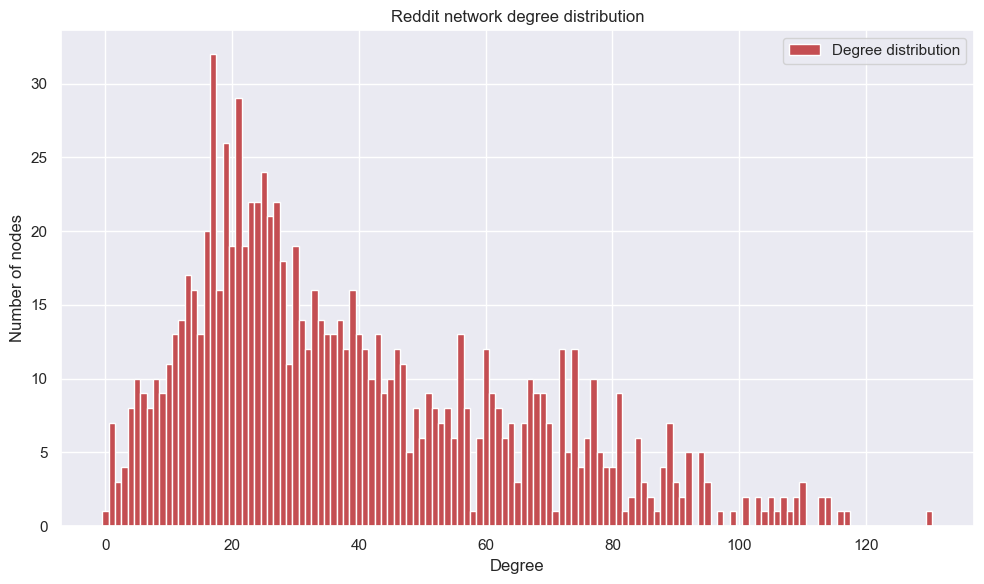

In [114]:
# Degrees in the graph
degrees = [G.degree(n) for n in G.nodes()]
bin_edges = np.linspace(0, max(degrees), max(degrees) + 1)

counts, bin_edges = np.histogram(degrees, bins=bin_edges)


plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], counts, width=1, label='Degree distribution', color='r')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Reddit network degree distribution')
plt.legend()
plt.tight_layout()
plt.show()
